# Описание проекта

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.
</div>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import re

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

! pip install phik
from phik.report import plot_correlation_matrix
from phik import report

     |████████████████████████████████| 686 kB 1.1 MB/s eta 0:00:01


## Загрузка данных

In [2]:
try:
    df_contract = pd.read_csv('/contract_new.csv.csv') 
    df_contract.name = 'contract'
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_contract.name = 'contract'

In [3]:
try:
    df_personal = pd.read_csv('/personal_new.csv') 
    df_personal.name = 'personal'
except:
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_personal.name = 'personal'

In [4]:
try:
    df_internet = pd.read_csv('/internet_new.csv') 
    df_internet.name = 'internet'
except:
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_internet.name = 'internet'

In [5]:
try:
    df_phone = pd.read_csv('/phone_new.csv') 
    df_phone.name = 'phone'
except:
    df_phone = pd.read_csv('/datasets/phone_new.csv')
    df_phone.name = 'phone'

##  Анализ и предобработка данных

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Функция для проверки информации 
</div>

In [6]:
def df_info(df):
    
    print(f'Датафрейм {df.name}')
    print('Первые 5 записей: ')
    print(df.head(5))
    print()
    print(f'Информация о датафрейме {df.name}')
    print(df.info())
    print()
    print(f'Описание данных датафрейма {df.name}')
    print(df.describe())

### Датафрейм contract

In [7]:
df_info(df_contract)

Датафрейм contract
Первые 5 записей: 
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  

Информация о датафрейме contract
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dt

In [8]:
print('Количество дубликатов во всех столбцах: {:.0f}'.format(df_contract.duplicated().sum()))
print('Количество дубликатов в столбце ID: {:.0f}'.format(df_contract.duplicated(subset=['customerID']).sum()))

Количество дубликатов во всех столбцах: 0
Количество дубликатов в столбце ID: 0


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <li>Дубликатов нет</li> 
    <li>Пропущенных значений нет</li> 
    <li>BeginDate и EndDate имееют неверный тип данных, лучше подойдет date, нужно поменять</li> 
</div>

In [9]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [10]:
print('Тип данных у столбца BeginDate: {:}'.format(
        type(df_contract['BeginDate'][0])))
#изменяем тип
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')

Тип данных у столбца BeginDate: <class 'str'>


In [11]:
df_contract['BeginDate'].dt.day.unique()

array([1])

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    Как видим полезной информации в днях нет, так как значение не уникальное, поэтому предлагаю разделить столбец и добавить два уникальных с годом и месяцем
</div>

In [12]:
df_contract['Begin_year'] = df_contract['BeginDate'].dt.year
df_contract['Begin_month'] = df_contract['BeginDate'].dt.month

In [13]:
print("Самое ранее значение столбца:", df_contract['BeginDate'].min())
print("Самое свежее значение столбца:", df_contract['BeginDate'].max())

Самое ранее значение столбца: 2013-10-01 00:00:00
Самое свежее значение столбца: 2020-02-01 00:00:00


In [14]:
df_contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [15]:
day_dataset = '2020-02-01'

In [16]:
# расчитаем период действия контракта
# когда контракт действителен, мы рассчитываем его в соответствии с параметром: day_dataset
# day_dataset - это 1 февраля 2020 года (максимальная дата в датафрейме)
df_contract['Contract_period'] = df_contract.query('EndDate != "No"')['EndDate']
df_contract['Contract_period'] = df_contract['Contract_period'].fillna(day_dataset)
df_contract['Contract_period'] = pd.to_datetime(df_contract['Contract_period'], format='%Y-%m-%d %H:%M:%S')
df_contract['Contract_period'] = (df_contract['Contract_period'] - df_contract['BeginDate']).dt.days

# создаем целевой столбец с информацией о том, действителен ли контракт
df_contract['Valid_client'] = [1 if x==True else 0 for x in df_contract['EndDate'] == "No" ]

In [17]:
df_contract = df_contract.drop(columns=['EndDate','BeginDate'])

In [18]:
df_contract['TotalCharges'].unique()

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

In [19]:
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
except:
    print('Есть проблемы с суммой начислений. Не удается преобразовать тип')

Есть проблемы с суммой начислений. Не удается преобразовать тип


In [20]:
#попробуем найти проблему
index = 0
list_index = []
for text in df_contract['TotalCharges']:
    numbers_float = re.findall(r"[0-9]*\.[0-9]*", text)
    numbers_int = re.findall(r"\d+", text)
    if len(numbers_float) != 1 and len(numbers_int) != 1:
        print(index, text)
        list_index.append(index)    
    index += 1

488  
753  
936  
1082  
1340  
3331  
3826  
4380  
5218  
6670  
6754  


In [21]:
df_contract.iloc[list_index]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Begin_year,Begin_month,Contract_period,Valid_client
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,,2020,2,0,1
753,3115-CZMZD,Two year,No,Mailed check,20.25,,2020,2,0,1
936,5709-LVOEQ,Two year,No,Mailed check,80.85,,2020,2,0,1
1082,4367-NUYAO,Two year,No,Mailed check,25.75,,2020,2,0,1
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,,2020,2,0,1
3331,7644-OMVMY,Two year,No,Mailed check,19.85,,2020,2,0,1
3826,3213-VVOLG,Two year,No,Mailed check,25.35,,2020,2,0,1
4380,2520-SGTTA,Two year,No,Mailed check,20.00,,2020,2,0,1
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,,2020,2,0,1
6670,4075-WKNIU,Two year,No,Mailed check,73.35,,2020,2,0,1


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    Итак, мы видим, что проблема со строками, где нет информации о суммарных начислениях 
</div>

In [22]:
print('Процент данных при удаление {:.2%} '.format(len(list_index) / len(df_contract)))

Процент данных при удаление 0.16% 


In [23]:
df_contract = df_contract.drop(list_index, axis=0)
df_contract = df_contract.reset_index(drop=True)

In [24]:
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
except:
    print('There is some problems with TotalCharges. Cannot convert type')

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    Закончили проверку и предобработку contact, теперь данные готовы
</div>

### Датафрейм personal

In [25]:
df_info(df_personal)

Датафрейм personal
Первые 5 записей: 
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Информация о датафрейме personal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Описание данных датафрейма personal
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min    

In [26]:
print('Количество дубликатов во всех столбцах: {:.0f}'.format(df_personal.duplicated().sum()))
print('Количество дубликатов в столбце ID: {:.0f}'.format(df_personal.duplicated(subset=['customerID']).sum()))

Количество дубликатов во всех столбцах: 0
Количество дубликатов в столбце ID: 0


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <li>Дубликатов нет</li> 
    <li>Пропущенных значений нет</li> 
    <li>Типы данных можно оставить</li> 
</div>

### Датафрейм internet

In [27]:
df_info(df_internet)

Датафрейм internet
Первые 5 записей: 
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  

Информация о датафрейме internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----

In [28]:
print('Количество дубликатов во всех столбцах: {:.0f}'.format(df_internet.duplicated().sum()))
print('Количество дубликатов в столбце ID: {:.0f}'.format(df_internet.duplicated(subset=['customerID']).sum()))

Количество дубликатов во всех столбцах: 0
Количество дубликатов в столбце ID: 0


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <li>Дубликатов нет</li> 
    <li>Пропущенных значений нет</li> 
    <li>Типы данных можно оставить</li> 
</div>

### Датафрейм phone

In [29]:
df_info(df_phone)

Датафрейм phone
Первые 5 записей: 
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Информация о датафрейме phone
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Описание данных датафрейма phone
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     0727-BMPLR            No
freq             1          3390


In [30]:
print('Количество дубликатов во всех столбцах: {:.0f}'.format(df_phone.duplicated().sum()))
print('Количество дубликатов в столбце ID: {:.0f}'.format(df_phone.duplicated(subset=['customerID']).sum()))

Количество дубликатов во всех столбцах: 0
Количество дубликатов в столбце ID: 0


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <li>Дубликатов нет</li> 
    <li>Пропущенных значений нет</li> 
    <li>Типы данных можно оставить</li> 
</div>

## Объединение данных

In [31]:
df = df_contract.   \
    merge(df_personal, on='customerID', how='left').   \
    merge(df_internet, on='customerID', how='left').   \
    merge(df_phone, on='customerID', how='left')
df.name = 'df'

In [32]:
df_info(df)

Датафрейм df
Первые 5 записей: 
   customerID            Type PaperlessBilling              PaymentMethod  \
0  7590-VHVEG  Month-to-month              Yes           Electronic check   
1  5575-GNVDE        One year               No               Mailed check   
2  3668-QPYBK  Month-to-month              Yes               Mailed check   
3  7795-CFOCW        One year               No  Bank transfer (automatic)   
4  9237-HQITU  Month-to-month              Yes           Electronic check   

   MonthlyCharges  TotalCharges  Begin_year  Begin_month  Contract_period  \
0           29.85         31.04        2020            1               31   
1           56.95       2071.84        2017            4             1036   
2           53.85        226.17        2019           10              123   
3           42.30       1960.60        2016            5             1371   
4           70.70        353.50        2019            9              153   

   Valid_client  ... Partner  Dependents I

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    После объединения имеем много пропусков, но данные важны, поэтому нужно их сохранить
</div>

## Исследовательский анализ

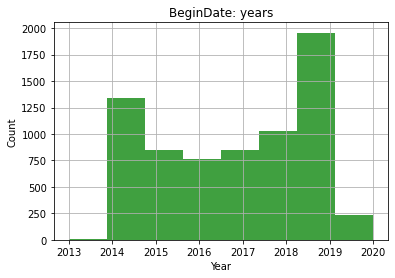

In [33]:
plt.hist(df_contract['Begin_year'], 8, facecolor='green', alpha=0.75)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('BeginDate: years')
plt.grid(True)

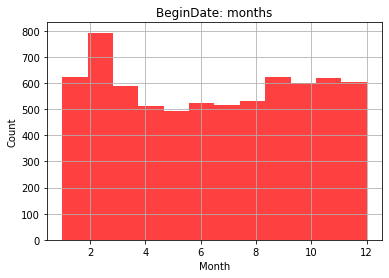

In [34]:
plt.hist(df_contract['Begin_month'], 12, facecolor='red', alpha=0.75)

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('BeginDate: months')
plt.grid(True)

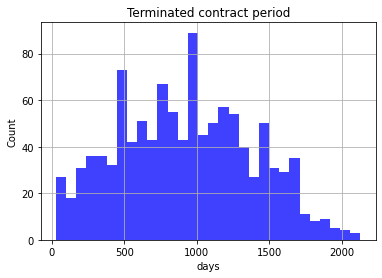

In [35]:
plt.hist(df[df['Valid_client'] == 0]['Contract_period'], 30, facecolor='blue', alpha=0.75)

plt.xlabel('days')
plt.ylabel('Count')
plt.title('Terminated contract period')
plt.grid(True)

In [36]:
df.corr(method="spearman").style.background_gradient('coolwarm')

,MonthlyCharges,TotalCharges,Begin_year,Begin_month,Contract_period,Valid_client,SeniorCitizen
MonthlyCharges,1.000000,0.646433,-0.289318,-0.025255,0.252350,-0.163761,0.220737
TotalCharges,0.646433,1.000000,-0.819913,-0.168348,0.876712,-0.138862,0.110690
Begin_year,-0.289318,-0.819913,1.000000,0.073270,-0.907627,0.349977,-0.029999
Begin_month,-0.025255,-0.168348,0.073270,1.000000,-0.201909,0.061637,0.029314
Contract_period,0.252350,0.876712,-0.907627,-0.201909,1.000000,-0.060622,0.012362
Valid_client,-0.163761,-0.138862,0.349977,0.061637,-0.060622,1.000000,-0.056444
SeniorCitizen,0.220737,0.110690,-0.029999,0.029314,0.012362,-0.056444,1.000000


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    Убрали ручное кодирование и матрицу phik, просто объединили данные и проверяли корреляцию
</div>

In [37]:
df = df.fillna('No')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Begin_year        7032 non-null   int64  
 7   Begin_month       7032 non-null   int64  
 8   Contract_period   7032 non-null   int64  
 9   Valid_client      7032 non-null   int64  
 10  gender            7032 non-null   object 
 11  SeniorCitizen     7032 non-null   int64  
 12  Partner           7032 non-null   object 
 13  Dependents        7032 non-null   object 
 14  InternetService   7032 non-null   object 
 15  OnlineSecurity    7032 non-null   object 
 16  OnlineBackup      7032 non-null   object 


## Подготовка данных

In [39]:
features = df.drop(columns=['customerID', 'Valid_client', 'Begin_year', 'Begin_month'])
target = df['Valid_client']

Text(0.5, 1.0, 'Comparison number of valid and terminated contracts')

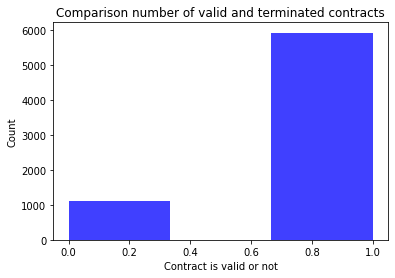

In [40]:
plt.hist(target, 3, facecolor='blue', alpha=0.75)

plt.xlabel('Contract is valid or not')
plt.ylabel('Count')
plt.title('Comparison number of valid and terminated contracts')

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
   Итак, target немного несбалансирована, но  это не является большой проблемой.
</div>

In [41]:
features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.25, random_state=80724, stratify=target)

In [42]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, drop='first') 

In [43]:
def standard_scaler(X_train, X_test, num_col_names, scaler):
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    return X_train_scaled, X_test_scaled

In [44]:
def normal_encoder(X_train, X_test, encoder):
    X_train_ohe = encoder.fit_transform(X_train)
    X_test_ohe = encoder.transform(X_test)

    encoder_col_names = encoder.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    return X_train_ohe, X_test_ohe

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Begin_year        7032 non-null   int64  
 7   Begin_month       7032 non-null   int64  
 8   Contract_period   7032 non-null   int64  
 9   Valid_client      7032 non-null   int64  
 10  gender            7032 non-null   object 
 11  SeniorCitizen     7032 non-null   int64  
 12  Partner           7032 non-null   object 
 13  Dependents        7032 non-null   object 
 14  InternetService   7032 non-null   object 
 15  OnlineSecurity    7032 non-null   object 
 16  OnlineBackup      7032 non-null   object 


In [46]:
num_col_names = ['MonthlyCharges', 'TotalCharges', 'Contract_period']
encoder_col_names = ['Type', 'PaperlessBilling', 'PaymentMethod',
                     'InternetService', 'OnlineSecurity',
                     'OnlineBackup', 'DeviceProtection',
                     'TechSupport', 'StreamingTV', 'StreamingMovies',
                     'MultipleLines', 'gender', 'Partner', 'Dependents']

In [47]:
features_train_ohe, features_test_ohe = normal_encoder(features_train[encoder_col_names], features_test[encoder_col_names], encoder)

In [48]:
features_train_scaled, features_test_scaled = standard_scaler(features_train, features_test, num_col_names, scaler) 

In [49]:
features_train = pd.concat([features_train_ohe, features_train_scaled], axis=1).reset_index(drop=True)
features_test = pd.concat([features_test_ohe, features_test_scaled], axis=1).reset_index(drop=True)

In [50]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(5274, 21)

(1758, 21)

(5274,)

(1758,)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Проверили кодирование данных после разбиения на выборки
</div>

## Обучение модели

### LogisticRegression

In [51]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

model_lr = LogisticRegression(n_jobs=-1, random_state=80724)

search_lr = GridSearchCV(model_lr, param_grid, cv=3, scoring='roc_auc', verbose = False)
search_lr.fit(features_train, target_train)

print('Лучшие параметры:', search_lr.best_params_)
print('Лучший результат:', search_lr.best_score_)

Лучшие параметры: {'C': 10}
Лучший результат: 0.762889646330095


In [52]:
predict_lr = search_lr.best_estimator_.predict_proba(features_train)[:, 1]

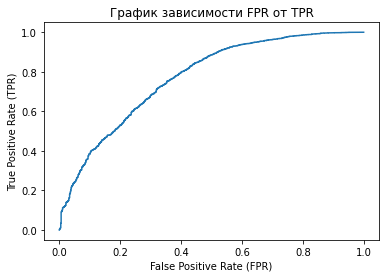

In [53]:
fpr, tpr, thresholds = roc_curve(target_train, predict_lr)  
plt.plot(fpr, tpr)     
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
 LogisticRegression Лучший результат: 0.76 Лучшие параметры: {'C': 1}
</div>

### CatBoostClassifier

In [54]:
model_cb = CatBoostClassifier(random_state = 80724)

In [55]:
param_cb = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}

In [56]:
grid_cb = GridSearchCV(estimator=model_cb, param_grid=param_cb, cv=3, scoring='roc_auc')

In [57]:
grid_cb.fit(features_train, target_train)

0:	learn: 0.6162869	total: 48.5ms	remaining: 48.4s
1:	learn: 0.5541046	total: 50.2ms	remaining: 25.1s
2:	learn: 0.5129282	total: 51.6ms	remaining: 17.2s
3:	learn: 0.4839273	total: 53.2ms	remaining: 13.2s
4:	learn: 0.4558823	total: 54.7ms	remaining: 10.9s
5:	learn: 0.4347688	total: 55.9ms	remaining: 9.27s
6:	learn: 0.4159343	total: 57.4ms	remaining: 8.14s
7:	learn: 0.4023039	total: 59.1ms	remaining: 7.33s
8:	learn: 0.3889975	total: 60.7ms	remaining: 6.68s
9:	learn: 0.3793357	total: 62.4ms	remaining: 6.18s
10:	learn: 0.3733453	total: 63.9ms	remaining: 5.75s
11:	learn: 0.3673993	total: 65.4ms	remaining: 5.39s
12:	learn: 0.3620969	total: 67ms	remaining: 5.09s
13:	learn: 0.3548561	total: 68.7ms	remaining: 4.84s
14:	learn: 0.3528385	total: 69.5ms	remaining: 4.57s
15:	learn: 0.3484947	total: 71.1ms	remaining: 4.38s
16:	learn: 0.3452173	total: 72.7ms	remaining: 4.2s
17:	learn: 0.3419013	total: 74.3ms	remaining: 4.05s
18:	learn: 0.3389927	total: 76ms	remaining: 3.92s
19:	learn: 0.3371311	total:

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f53d2627b80>,
             param_grid={'depth': [5, 10],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='roc_auc')

In [58]:
pred_cb = grid_cb.best_estimator_.predict(features_train)

In [59]:

print('Лучший результат:', grid_cb.best_score_)
print('Лучший параметры:', grid_cb.best_params_)

Лучший результат: 0.8998200159014252
Лучший параметры: {'depth': 5, 'learning_rate': 0.1}



<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
 CatBoostClassifier Лучший результат: 0.89 Лучшие параметры:{'depth': 5, 'learning_rate': 0.1}
</div>

Полностью поменял подход к моделированию, оставил 2 модели, по итогам обучения тестирую одну с лучшим результатом

### Выбор лучшей модели


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
 Лучшую метрику показала модель CatBoostClassifier, проверим на тестовой выборке
</div>

In [60]:
predict_cb = grid_cb.best_estimator_.predict_proba(features_test)[:, 1]

In [61]:
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(target_test, predict_cb),3)}')

Метрика ROC-AUC на тестовой выборке: 0.911


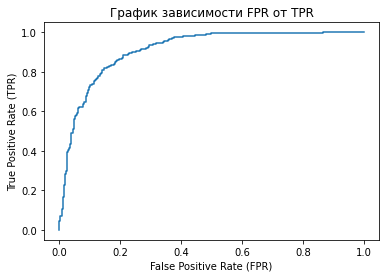

In [62]:
fpr, tpr, thresholds = roc_curve(target_test, predict_cb)   
plt.plot(fpr, tpr)     
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

In [63]:
main_sign = pd.DataFrame(grid_cb.best_estimator_.feature_importances_, index = features_test.columns, columns=['MainSign'])
main_sign = main_sign.sort_values(by='MainSign', ascending=False)
main_sign.iloc[:10]

,MainSign
Contract_period,44.834513
TotalCharges,12.306058
MonthlyCharges,11.962629
x0_Two year,4.017740
x12_Yes,3.502937
x10_Yes,2.342190
x13_Yes,2.257658
x1_Yes,2.246790
x0_One year,1.984535
x2_Mailed check,1.931510


In [66]:
main_sign

,MainSign
Contract_period,44.834513
TotalCharges,12.306058
MonthlyCharges,11.962629
x0_Two year,4.017740
x12_Yes,3.502937
x10_Yes,2.342190
x13_Yes,2.257658
x1_Yes,2.246790
x0_One year,1.984535
x2_Mailed check,1.931510


Самые важные признаки влияющие на результат - Contract_period, MonthlyCharges, TotalCharges.

In [64]:
y_pred = grid_cb.best_estimator_.predict(features_test)

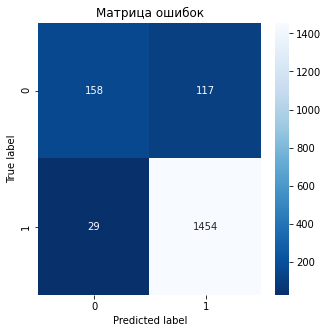

In [65]:
cm = confusion_matrix(target_test, y_pred)
plt.figure(figsize = (5,5))
plt.title("Матрица ошибок")
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Predicted label')
plt.ylabel('True label');

<ul>Результаты модели:
    <li>истинно положительный (TP) - 152</li>
    <li>истинно отрицательный (TN) - 1453</li>
    <li>ложноположительный результат (FP), ошибка I рода - 113 <br>
    <li>ложноотрицательный результат (FN), ошибка II рода 30</li>
</ul>

## Вывод

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    В данном проекте мы разработали модель по предсказанию перестанет ли клиент пользоваться услугами связи сотовой связи или нет. На входе получили 4 датасета с общий ключевым полем customerID. Далее проделали следующую работу:<br>
     <ul>
     <li>Провели предобработку данных: , заполнили пропуски, проверили дубликаты, изменили типы данных. Провели исследователький анализ</li>
     <li>Добавили новый столбец Contract_period с общим временем пользования услугами связи</li>
     <li>Объединили все датасеты в общий, заполнили пропущенные значения на 0.</li>
     <li>Подготовили данные для обучения моделей, удалили лишние признаки.</li>
     <li>Обучили две модели с подбором гипперпараметров - линейную классификацию и CatBoostClassifier.</li>
     <li>Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 89%</li>
    </ul>
    <ul>Все признаки на которых обучалась модель и их влияение на результат:
        <li>Contract_period	44.834513</li>
          <li>TotalCharges	12.306058</li>
          <li>MonthlyCharges	11.962629</li>
          <li>x0_Two year	4.017740</li>
          <li>x12_Yes	3.502937</li>
          <li>x10_Yes	2.342190</li>
          <li>x13_Yes	2.257658</li>
          <li>x1_Yes	2.246790</li>
          <li>x0_One year	1.984535</li>
          <li>x2_Mailed check	1.931510</li>
          <li>x5_Yes	1.923671</li>
         <li>x6_Yes	1.793556</li>
         <li>x11_Male	1.646579</li>
         <li>x2_Electronic check	1.455268</li>
         <li>x9_Yes	1.345031</li>
         <li>x4_Yes	1.091684</li>
         <li>x2_Credit card (automatic)	1.060519</li>
         <li>x7_Yes	1.035172</li>
         <li>x8_Yes	0.711889</li>
         <li>x3_Fiber optic	0.316885</li>
        <li>x3_No	0.233185</li>
    </ul>
    <ul>Результаты CatBoostClassifier на тестовой выборке:
    <li>истинно положительный (TP) - 152</li>
    <li>истинно отрицательный (TN) - 1453</li>
    <li>ложноположительный результат (FP), ошибка I рода - 113
    <li>ложноотрицательный результат (FN), ошибка II рода 30</li>
    <li>Самые важные признаки влияющие на результат - Contract_period, MonthlyCharges, TotalCharges.</li>
    <li>Метрика ROC-AUC на тестовой выборке: 0.918</li>
    <li>Лучшие параметры:{'depth': 5, 'learning_rate': 0.1}</li>
    </ul>
    <br>
    Разработанная модель могла бы помочь им спрогнозировать отток клиентов.
     <br>
    Так же ее можно улучшить если добавить больше актуальных данных
</div>